# Imbalanced Classification

## Loading Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import interp
from sklearn.preprocessing import scale
from sklearn.metrics import precision_score, recall_score, roc_auc_score, accuracy_score, roc_curve, auc, confusion_matrix
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, train_test_split
from xgboost import XGBClassifier
import itertools
import glmnet
import xgboost as xgb
import shap
import seaborn as sns
sns.set_style("ticks")
mpl.rcParams['axes.linewidth'] = 3 
mpl.rcParams['lines.linewidth'] =7
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
import warnings 
warnings.filterwarnings("ignore")
%matplotlib inline

# Unused Libraries here
# import keras
# from bayes_opt import BayesianOptimization
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# from fancyimpute import SoftImpute, IterativeImputer

# Functions

In [47]:
#*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
# Function: _x_y_maker

def _x_y_maker(df, target, to_drop):
    """
    A function to receive the dataframe and make the X, and Y matrices:
    ----------
    parameters
    
    input: dataframe df
           string target (class label)
           list[string] to_drop (list of columns need to be dropped)
           
    output: dataframe Feature matrix (df_X)
            Target vector (Y)
    """    
    Targets = df[target]
    to_drop.append(target)
    Features = df.drop(to_drop, axis = 1)
    Scaled_Features = scale(Features.values)
    df_X = pd.DataFrame(data = Scaled_Features, columns = Features.columns.tolist())
    Y = Targets.values
    
    return df_X, Y

#*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
# Function: _plot_roc_nfolds_xgboost

def _plot_roc_nfolds_xgboost(df_X, Y,
                                     n_folds = 10,
                                     n_estimators = 100,
                                     learning_rate = 0.05,
                                     max_depth = 3,
                                     min_child_weight = 5.0,
                                     gamma = 0.5,
                                     reg_alpha = 0.0,
                                     reg_lambda = 1.0,
                                     subsample = 0.9,
                                     objective = "binary:logistic",
                                     scale_pos_weight = 1.0,
                                     shuffle = True,
                                     random_state = 1367
                            ):
    """
    a function to plot k-fold cv ROC using xgboost
    input parameters:
                     df_X : features : pandas dataframe (numpy array will be built inside the function)
                     Y : targets
                     n_folds : number of cv folds (default = 10)
                     n_estimators = number of trees (default = 100)
                     learning_rate : step size of xgboost (default = 0.05)
                     max_depth : maximum tree depth for xgboost (default = 3)
                     min_child_weight : (default = 5.0)
                     gamma : (default = 0.5)
                     reg_alpha : lasso penalty (L1) (default = 0.0)
                     reg_lambda : ridge penalty (L2) (default = 1.0)
                     subsample : subsample fraction (default = 0.9)
                     objective : objective function for ML (default = "binary:logistic" for classification)
                     scale_pos_weight : (default = 1.0)
                     shuffle : shuffle flag for cv (default = True)
                     random_state : (default = 1367)
    
    """

    # Defining the data
    X = scale(df_X.values)
    y = Y
    n_samples, n_features = X.shape

    # Run classifier with cross-validation and plot ROC curves
    cv = StratifiedKFold(n_splits = n_folds , shuffle = shuffle , random_state = random_state)
    classifier = XGBClassifier(learning_rate = learning_rate,
                               n_estimators = n_estimators,
                               max_depth = max_depth,
                               min_child_weight = min_child_weight,
                               gamma = gamma,
                               reg_alpha = reg_alpha,
                               reg_lambda = reg_lambda,
                               subsample = subsample,
                               objective = objective,
                               nthread = 4,
                               scale_pos_weight = 1.,
                               base_score = np.mean(y),
                               seed = random_state,
                               random_state = random_state)
    

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    plt.figure(figsize=(18 , 13))
    i = 0
    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=3, alpha=0.5, 
                 label="ROC Fold %d (AUC = %0.2f)" % (i+1, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle="--", lw=3, color="k",
             label="Luck", alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color="navy",
             label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
             lw=4)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color="grey", alpha=.4,
                     label=r"$\pm$ 1 Standard Deviation")

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel("False Positive Rate" ,  fontweight = "bold" , fontsize=30)
    plt.ylabel("True Positive Rate",fontweight = "bold" , fontsize=30)
    plt.tick_params(axis="both", which="major", labelsize=20)
    plt.legend( prop={"size":20} , loc = 4)
    # plt.savefig("./roc_xgboost.pdf" ,bbox_inches="tight")
    plt.show()

#*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
# Function: _permute

def _permute(df, random_state):
    """
    a funtion to permute the rows of features and add them
    to the dataframe as noisy features to explore stability
    input parameters:
                    df : pandas dataframe
                    random_state : random seed for noisy features
    """
    normal_df = df.copy().reset_index(drop = True)
    noisy_df = df.copy()
    noisy_df.rename(columns = {col : "noisy_" + col for col in noisy_df.columns}, inplace = True)
    np.random.seed(seed = random_state)
    noisy_df = noisy_df.reindex(np.random.permutation(noisy_df.index))
    merged_df = pd.concat([normal_df, noisy_df.reset_index(drop = True)] , axis = 1)
    
    return merged_df
    
#*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
# Function: _my_feature_selector

def _my_feature_selector(X, Y, n_iter = 1,
                                  num_boost_round = 1000,
                                  nfold = 10,
                                  stratified = True,
                                  metrics = ("auc"),
                                  early_stopping_rounds = 50,
                                  seed = 1367,
                                  shuffle = True,
                                  show_stdv = False,
                                  params = None,
                                  importance_type = "total_gain",
                                  callbacks = False,
                                  verbose_eval = False):
    """
    a function to run xgboost kfolds cv and train the model based on the best boosting round of each iteration.
    for different number of iterations. at each iteration noisy features are added as well. at each iteration
    internal and external cv calculated.
    NOTE: it is recommended to use ad-hoc parameters to make sure the model is under-fitted for the sake of feature selection
    input parameters:
                    X: features (pandas dataframe or numpy array)
                    Y: targets (1D array or list)
                    n_iter: total number of iterations (default = 1)
                    num_boost_rounds: max number of boosting rounds, (default = 1000)
                    stratified: stratificaiton of the targets (default = True)
                    metrics: classification/regression metrics (default = ("auc))
                    early_stopping_rounds: the criteria for stopping if the test metric is not improved (default = 20)
                    seed: random seed (default = 1367)
                    shuffle: shuffling the data (default = True)
                    show_stdv = showing standard deviation of cv results (default = False)
                    params = set of parameters for xgboost cv
                            (default_params = {
                                               "eval_metric" : "auc",
                                               "tree_method": "hist",
                                               "objective" : "binary:logistic",
                                               "learning_rate" : 0.05,
                                               "max_depth": 2,
                                               "min_child_weight": 1,
                                               "gamma" : 0.0,
                                               "reg_alpha" : 0.0,
                                               "reg_lambda" : 1.0,
                                               "subsample" : 0.9,
                                               "max_delta_step": 1,
                                               "silent" : 1,
                                               "nthread" : 4,
                                               "scale_pos_weight" : 1
                                               }
                            )
                    importance_type = importance type of xgboost as string (default = "total_gain")
                                      the other options will be "weight", "gain", "cover", and "total_cover"
                    callbacks = printing callbacks for xgboost cv
                                (defaults = False, if True: [xgb.callback.print_evaluation(show_stdv = show_stdv),
                                                             xgb.callback.early_stop(early_stopping_rounds)])
                    verbose_eval : a flag to show the result during train on train/test sets (default = False)
    outputs:
            outputs_dict: a dict contains the fitted models, internal and external cv results for train/test sets
            df_selected: a dataframe contains feature names with their frequency of being selected at each run of folds
    """
    # callback flag
    if(callbacks == True):
        callbacks = [xgb.callback.print_evaluation(show_stdv = show_stdv),
                     xgb.callback.early_stop(early_stopping_rounds)]
    else:
        callbacks = None
    
    # params
    default_params = {
                      "eval_metric" : "auc",
                      "tree_method": "hist",
                      "objective" : "binary:logistic",
                      "learning_rate" : 0.05,
                      "max_depth": 2,
                      "min_child_weight": 1,
                      "gamma" : 0.0,
                      "reg_alpha" : 0.0,
                      "reg_lambda" : 1.0,
                      "subsample" : 0.9,
                      "max_delta_step": 1,
                      "silent" : 1,
                      "nthread" : 4,
                      "scale_pos_weight" : 1,
                      "base_score" : np.mean(Y)
                     }
    # updating the default parameters with the input
    if params is not None:
        for key, val in params.items():
            default_params[key] = val
            
    # total results list
    int_cv_train = []
    int_cv_test = []
    ext_cv_train = []
    ext_cv_test = []
    bst_list = []
    
    # main loop
    for iteration in range(n_iter):
        
        # results list at iteration
        int_cv_train2 = []
        int_cv_test2 = []
        ext_cv_train2 = []
        ext_cv_test2 = []
        
        # update random state 
        random_state = seed * iteration 
    
        # adding noise to data
        X_permuted = _permute(df = X, random_state = random_state)
        cols = X_permuted.columns.tolist()
        Xval = X_permuted.values

        # building DMatrix for training/testing + kfolds cv
        cv = StratifiedKFold(n_splits = nfold , shuffle = shuffle , random_state = random_state)

        for train_index, test_index in cv.split(Xval, Y):
            Xval_train = Xval[train_index]
            Xval_test = Xval[test_index]
            Y_train = Y[train_index]
            Y_test = Y[test_index]

            X_train = pd.DataFrame(data = Xval_train, columns = cols)
            X_test = pd.DataFrame(data = Xval_test, columns = cols)
            
            dtrain = xgb.DMatrix(data = X_train, label = Y_train)
            dtest = xgb.DMatrix(data = X_test, label = Y_test)

            # watchlist during final training
            watchlist = [(dtrain,"train"), (dtest,"eval")]
            
            # a dict to store training results
            evals_result = {}
            
            # xgb cv
            cv_results = xgb.cv(params = default_params,
                                dtrain = dtrain,
                                num_boost_round = num_boost_round,
                                nfold = nfold,
                                stratified = stratified,
                                metrics = metrics,
                                early_stopping_rounds = early_stopping_rounds,
                                seed = random_state,
                                verbose_eval = verbose_eval,
                                shuffle = shuffle,
                                callbacks = callbacks)
            int_cv_train.append(cv_results.iloc[-1][0])
            int_cv_test.append(cv_results.iloc[-1][2])
            int_cv_train2.append(cv_results.iloc[-1][0])
            int_cv_test2.append(cv_results.iloc[-1][2])
            
            # xgb train
            bst = xgb.train(params = default_params,
                            dtrain = dtrain,
                            num_boost_round = len(cv_results) - 1,
                            evals = watchlist,
                            evals_result = evals_result,
                            verbose_eval = verbose_eval)
            # appending outputs
            bst_list.append(bst)
            ext_cv_train.append(evals_result["train"]["auc"][-1])
            ext_cv_test.append(evals_result["eval"]["auc"][-1])
            ext_cv_train2.append(evals_result["train"]["auc"][-1])
            ext_cv_test2.append(evals_result["eval"]["auc"][-1])
        
        print(F"-*-*-*-*-*-*-*-*- Iteration {iteration + 1} -*-*-*-*-*-*-*-*")
        print(F"-*-*- Internal-{nfold} Folds-CV-Train = {np.mean(int_cv_train2):.3} +/- {np.std(int_cv_train2):.3} -*-*- Internal-{nfold} Folds-CV-Test = {np.mean(int_cv_test2):.3} +/- {np.std(int_cv_test2):.3} -*-*")
        print(F"-*-*- External-{nfold} Folds-CV-Train = {np.mean(ext_cv_train2):.3} +/- {np.std(ext_cv_train2):.3} -*-*- External-{nfold} Folds-CV-Test = {np.mean(ext_cv_test2):.3} +/- {np.std(ext_cv_test2):.3} -*-*")
    
    # putting together the outputs in one dict
    outputs = {}
    outputs["bst"] = bst_list
    outputs["int_cv_train"] = int_cv_train
    outputs["int_cv_test"] = int_cv_test
    outputs["ext_cv_train"] = ext_cv_train
    outputs["ext_cv_test"] = ext_cv_test
    

    pruned_features = []
    for bst_ in outputs["bst"]:
        features_gain = bst_.get_score(importance_type = importance_type)
        for key, value in features_gain.items():
            pruned_features.append(key)

    unique_elements, counts_elements = np.unique(pruned_features, return_counts = True)
    counts_elements = [float(i) for i in list(counts_elements)]
    df_features = pd.DataFrame(data = {"columns" : list(unique_elements) , "count" : counts_elements})
    df_features.sort_values(by = ["count"], ascending = False, inplace = True)

    # plotting
    plt.figure()
    df_features.sort_values(by = ["count"]).plot.barh(x = "columns", y = "count", color = "pink" , figsize = (8,8))
    plt.show()

    plt.figure(figsize = (16,12))

    plt.subplot(2,2,1)
    plt.title(F"Internal {nfold} CV {metrics.upper()} - Train", fontsize = 20)
    plt.hist(outputs["int_cv_train"], bins = 20, color = "lightgreen")

    plt.subplot(2,2,2)
    plt.title(F"Internal {nfold} CV {metrics.upper()} - Test", fontsize = 20)
    plt.hist(outputs["int_cv_test"], bins = 20, color = "lightgreen")

    plt.subplot(2,2,3)
    plt.title(F"External {nfold} CV {metrics.upper()} - Train", fontsize = 20)
    plt.hist(outputs["ext_cv_train"], bins = 20, color = "lightblue")

    plt.subplot(2,2,4)
    plt.title(F"External {nfold} CV {metrics.upper()} - Test", fontsize = 20)
    plt.hist(outputs["ext_cv_test"], bins = 20, color = "lightblue")

    plt.show()
    
    return outputs, df_features
#*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
# Function: Confidence Interval calculator for 95% significance

def _ConfidenceInterval(score, n):
    """
    confidence interval for 95% significance level
    input: score such as accuracy, auc
           the size of test set n
    """
    
    CI_range = 1.96 * np.sqrt( (score * (1 - score)) / n)
    CI_pos = score + CI_range
    CI_neg = score - CI_range
    if(CI_neg < 0):
        CI_neg = 0
        
    return CI_neg, CI_pos

#*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
# Function: _bst_shap

def _bst_shap(X, Y, num_boost_round = 1000,
                                    nfold = 10,
                                    stratified = True,
                                    metrics = ("auc"),
                                    early_stopping_rounds = 50,
                                    seed = 1367,
                                    shuffle = True,
                                    show_stdv = False,
                                    params = None,
                                    callbacks = False):
    """
    a function to run xgboost kfolds cv with the params and train the model based on best boosting rounds
    input parameters:
                    X: features
                    Y: targets
                    num_boost_rounds: max number of boosting rounds, (default = 1000)
                    stratified: stratificaiton of the targets (default = True)
                    metrics: classification/regression metrics (default = ("auc))
                    early_stopping_rounds: the criteria for stopping if the test metric is not improved (default = 20)
                    seed: random seed (default = 1367)
                    shuffle: shuffling the data (default = True)
                    show_stdv = showing standard deviation of cv results (default = False)
                    params = set of parameters for xgboost cv ( default_params = {
                                                                                  "eval_metric" : "auc",
                                                                                  "tree_method": "hist",
                                                                                  "objective" : "binary:logistic",
                                                                                  "learning_rate" : 0.05,
                                                                                  "max_depth": 2,
                                                                                  "min_child_weight": 5,
                                                                                  "gamma" : 0.0,
                                                                                  "reg_alpha" : 0.0,
                                                                                  "reg_lambda" : 1.0,
                                                                                  "subsample" : 0.9,
                                                                                  "silent" : 1,
                                                                                  "nthread" : 4,
                                                                                  "scale_pos_weight" : 1
                                                                                 }
                                                                    )
                   callbacks = printing callbacks for xgboost cv (defaults: [xgb.callback.print_evaluation(show_stdv = show_stdv),
                                                                             xgb.callback.early_stop(early_stopping_rounds)])
    outputs:
            bst: the trained model based on optimum number of boosting rounds
            cv_results: a dataframe contains the cv-results (train/test + std of train/test) for metric
    """
    # callback flag
    if(callbacks == True):
        callbacks = [xgb.callback.print_evaluation(show_stdv = show_stdv),
                     xgb.callback.early_stop(early_stopping_rounds)]
    else:
        callbacks = None
    
    # params
    default_params = {
                      "eval_metric" : "auc",
                      "tree_method": "hist",
                      "objective" : "binary:logistic",
                      "learning_rate" : 0.05,
                      "max_depth": 2,
                      "min_child_weight": 1,
                      "gamma" : 0.0,
                      "reg_alpha" : 0.0,
                      "reg_lambda" : 1.0,
                      "subsample" : 0.9,
                      "max_delta_step": 1,
                      "silent" : 1,
                      "nthread" : 4
                     }
    # updating the default parameters with the input
    if params is not None:
        for key, val in params.items():
            default_params[key] = val

    # building DMatrix for training
    dtrain = xgb.DMatrix(data = X, label = Y)
    print("-*-*-*-*-*-*-* CV Started *-*-*-*-*-*-*-")
    cv_results = xgb.cv(params = default_params,
                        dtrain = dtrain,
                        num_boost_round = num_boost_round,
                        nfold = nfold,
                        stratified = stratified,
                        metrics = metrics,
                        early_stopping_rounds = early_stopping_rounds,
                        seed = seed,
                        shuffle = shuffle,
                        callbacks = callbacks)
    print(F"*-*- Boosting Round = {len(cv_results) - 1} -*-*- Train = {cv_results.iloc[-1][0]:.3} -*-*- Test = {cv_results.iloc[-1][2]:.3} -*-*")
    print("-*-*-*-*-*-*-* Train Started *-*-*-*-*-*-*-")
    bst = xgb.train(params = default_params,
                    dtrain = dtrain,
                    num_boost_round = len(cv_results) - 1,
                   )
    
    return bst, cv_results

#*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
# Function: _plot_xgboost_cv_score

def _plot_xgboost_cv_score(cv_results):
    """
    a function to plot train/test cv score for 
    """

    import matplotlib as mpl
    mpl.rcParams['axes.linewidth'] = 3 
    mpl.rcParams['lines.linewidth'] = 2
    plt.figure(figsize=(10,8))
    plt.errorbar(range(cv_results.shape[0]), cv_results["train-auc-mean"],
                yerr=cv_results["train-auc-std"], fmt = "--", ecolor="lightgreen", c = "navy", label = "Train (9-Folds)")

    plt.errorbar(range(cv_results.shape[0]), cv_results["test-auc-mean"],
                yerr=cv_results["test-auc-std"], fmt = "--", ecolor="lightblue", c = "red", label = "Test (1-Fold)")


    plt.xlabel("# of Boosting Rounds" ,  fontweight = "bold" , fontsize=30)
    plt.ylabel("AUC",fontweight = "bold" , fontsize=30)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.legend(loc = 4, prop={'size': 20})
    plt.show()
    
#*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
# Function: _plot_importance

def _plot_importance(bst, importance_type = "total_gain", color = "pink", figsize = (10,10)):
    """
    a function to plot feature importance in xgboost
    """
    from xgboost import plot_importance
    from pylab import rcParams
    rcParams['figure.figsize'] = figsize
    plot_importance(bst, importance_type = importance_type, color = color, xlabel = importance_type)
    plt.show()

#*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
# Function: _plot_confusion_matrix
def _plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize = 20)
    plt.xlabel('Predicted label', fontsize = 20)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.tight_layout()

#*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
# Function: _clf_xgboost

def _clf_xgboost(df_X, Y, test_size, n_folds):
    X = df_X.values
    clf = XGBClassifier(learning_rate = 0.05,
                                n_estimators = 100,
                                max_depth = 3,
                                min_child_weight = 5.,
                               # max_delta_step= 1,
                                gamma = 0.5,
                                reg_alpha = 0.0,
                                reg_lambda = 1.0,
                                subsample = 0.9,
                                colsample_bytree = 0.9,
                                objective = "binary:logistic",
                                nthread = 4,
                                #scale_pos_weight = (len(Y) - sum(Y)) / sum(Y),
                                base_score = np.mean(Y),
                                seed = 1367,
                                random_state = 1367)
    
    X_train, X_test, y_train, y_test = train_test_split(df_X, Y, test_size = test_size, shuffle = True, random_state = 1367, stratify = Y)
    clf.fit(X_train, y_train, eval_metric="auc", early_stopping_rounds = 50, verbose = False, eval_set=[(X_test, y_test)])
    accuracy_score = clf.score(X_test, y_test)
    cv_roc_score = cross_val_score(clf, X, Y, cv = n_folds, scoring = "roc_auc")
    y_pred_prob = clf.predict_proba(X_test)
    roc_score = roc_auc_score(y_test, y_pred_prob[:,1])
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:,1])
    optimal_idx = np.argmax(np.abs(tpr - fpr))
    optimal_threshold = thresholds[optimal_idx]
    
    return accuracy_score, roc_score, cv_roc_score, y_pred_prob, X_test, y_test, optimal_threshold

#*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
# Function: _xgboost_auc_hist
def _xgboost_auc_hist(df_X, Y, n_iterations = 100, alpha = 0.95):
    """
    plot histogram of ROC AUC for N stratified classification for 95% significance level
    """

    n_size = int(len(Y) * 0.30)

    # Main Loop
    scores = list()
    for i in range(n_iterations):
        # split the data into train/test sets
        X_train, X_test, y_train, y_test = train_test_split(df_X, Y, test_size = n_size, shuffle = True, random_state = 1367 * i , stratify = Y)
        # fit the xgboost classifier
        clf = XGBClassifier(learning_rate = 0.05,
                                    n_estimators = 100,
                                    max_depth = 3,
                                    min_child_weight = 5.,
                                   # max_delta_step= 1,
                                    gamma = 0.5,
                                    reg_alpha = 0.0,
                                    reg_lambda = 1.0,
                                    subsample = 0.9,
                                    colsample_bytree = 0.9,
                                    objective = "binary:logistic",
                                    nthread = 4,
                                    #scale_pos_weight = (len(Y) - sum(Y)) / sum(Y),
                                    base_score = np.mean(Y),
                                    seed = 1367 * i ,
                                    random_state = 1367 * i)
        clf.fit(X_train, y_train, eval_metric = "auc", early_stopping_rounds = 50, verbose = False, eval_set = [(X_test, y_test)])
        # evaluate model
        predictions = clf.predict_proba(X_test)[:,1]
        pred_auc = roc_auc_score(y_test, predictions)
        scores.append(pred_auc)

    # Ploting the scores
    plt.figure(figsize=(10,5))
    plt.hist(scores, color = "pink")
    plt.xlabel("ROC AUC", fontsize = 30)
    plt.tick_params(axis = "both", which = "major", labelsize = 15)
    plt.show()

    # confidence intervals
    alpha = 0.95
    p = ((1.0 - alpha)/2.0) * 100
    lower = max(0.0, np.percentile(scores, p))
    p = (alpha + ((1.0 - alpha)/2.0)) * 100
    upper = min(1.0, np.percentile(scores, p))
    print(F"{alpha*100}% Significance Level - ROC AUC Confidence Interval= [{lower:.3f} , {upper:.3f}]")
    
#*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
# Function: _glmnet

def _glmnet(X, Y, alpha = 0.1, n_splits = 10, scoring = "roc_auc"):
    """
    a function for standard glmnet
    input parameters: pandas dataframe X
                      class labels Y
                      alpha = 0.1
                      n_splits = 10
                      scoring = "roc_auc"
    output: glmnet model 

    """  
    model = glmnet.LogitNet(alpha = alpha,
                     n_lambda = 100,
                     n_splits = n_splits,
                     cut_point = 1.0,
                     scoring = scoring,
                     n_jobs = -1,
                     random_state = 1367)
    model.fit(X, Y)
    
    return model

#*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
# Function: _plot_glmnet_cv_score

def _plot_glmnet_cv_score(model):
    """
    a function to plot cv scores vs lambda
    parameters:
               model : a fitted glmnet object
    """
    mpl.rcParams['axes.linewidth'] = 3 
    mpl.rcParams['lines.linewidth'] =2
    plt.figure(figsize=(10,6))
    plt.errorbar(-np.log(model.lambda_path_), model.cv_mean_score_, yerr=model.cv_standard_error_ , c = "r", ecolor="k", marker = "o" )
    plt.vlines(-np.log(model.lambda_best_), ymin = min(model.cv_mean_score_) - 0.05 , ymax = max(model.cv_mean_score_) + 0.05, lw = 3, linestyles = "--", colors = "b" ,label = "best $\lambda$")
    plt.vlines(-np.log(model.lambda_max_), ymin = min(model.cv_mean_score_) - 0.05 , ymax = max(model.cv_mean_score_) + 0.05, lw = 3, linestyles = "--", colors = "c" ,label = "max $\lambda$")
    plt.tick_params(axis='both', which='major', labelsize = 12)
    plt.grid(True)
    plt.ylim([min(model.cv_mean_score_) - 0.05, max(model.cv_mean_score_) + 0.05])
    plt.legend(loc = 4, prop={'size': 20})
    plt.xlabel("$-Log(\lambda)$" , fontsize = 20)
    plt.ylabel(F"Mean {model.n_splits} Folds CV {(model.scoring).upper()}", fontsize = 20)
    plt.title(F"Best $\lambda$ = {model.lambda_best_[0]:.2} with {len(np.nonzero(  model.coef_)[1])} Features" , fontsize = 20)
    plt.show()

#*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
# Function: _plot_glmnet_coeff_path

def _plot_glmnet_coeff_path(model, df):
    """
    a function to plot coefficients vs lambda
    parameters:
               model : a fitted glmnet object
               df: in case that the input is the pandas dataframe,
                   the column names of the coeff. will appear as a legend
    """
    mpl.rcParams['axes.linewidth'] = 3 
    mpl.rcParams['lines.linewidth'] =2
    plt.figure(figsize=(10,6))
    if not df.empty:
        for i in list(np.nonzero(np.reshape(model.coef_, (1,-1)))[1]):
            plt.plot(-np.log(model.lambda_path_) ,(model.coef_path_.reshape(-1,model.coef_path_.shape[-1]))[i,:], label = df.columns.values.tolist()[i]);
        plt.legend(loc= "right", bbox_to_anchor=(1.2 , .5), ncol=1, fancybox=True, shadow=True)

    else:
        for i in list(np.nonzero(np.reshape(model.coef_, (1,-1)))[1]):
            plt.plot(-np.log(model.lambda_path_) ,(model.coef_path_.reshape(-1, model.coef_path_.shape[-1]))[i,:]);
            
    plt.tick_params(axis='both', which='major', labelsize = 12)    
    plt.ylabel("Coefficients", fontsize = 20)
    plt.xlabel("-$Log(\lambda)$", fontsize = 20)
    plt.title(F"Best $\lambda$ = {model.lambda_best_[0]:.2} with {len(np.nonzero(model.coef_)[1])} Features" , fontsize = 20)
    plt.grid(True)
    plt.show()
    
#*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
# Function: _df_glmnet_coeff_path

def _df_glmnet_coeff_path(model, df):
    """
    a function to build a dataframe for nonzero coeff.
    parameters:
               model : a fitted glmnet object
               df: in case that the input is the pandas dataframe,
                   the column names of the coeff. will appear as a legend
                   
    """
    idx = list(np.nonzero(np.reshape(model.coef_, (1,-1)))[1])
    dct = dict( zip([df.columns.tolist()[i] for i in idx], [model.coef_[0][i] for i in idx]))
        
    return pd.DataFrame(data = dct.items() , columns = ["Features", "Coeffs"]).sort_values(by = "Coeffs", ascending = False).reset_index(drop = True)

#*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
# Function: _glmnet_best_score_alpha

def _glmnet_best_score_alpha(X, Y):
    """
    a function to run glmnet for different alpha
    """
    
    def logitnet_nonzero_coef(g):
        idx = np.where(g.coef_[0] != 0)[0]
        return pd.DataFrame({"idx": idx, "coef": g.coef_[0][idx]})

    alpha_list = np.arange(0.0, 0.5, 0.05)
    mean_auc = []
    std_auc = []
    n_features = []
    for alpha in alpha_list:
        model = _glmnet(X, Y, alpha = alpha)
        mean_auc.append(model.cv_mean_score_[model.lambda_best_inx_])
        std_auc.append(model.cv_standard_error_[model.lambda_best_inx_])
        fe = logitnet_nonzero_coef(model)
        n_features.append(fe.shape[0])
        
    mpl.rcParams['axes.linewidth'] = 3 
    mpl.rcParams['lines.linewidth'] =2
    plt.figure(figsize=(12,6))

    plt.subplot(1,2,1)
    plt.errorbar(alpha_list, mean_auc, yerr = std_auc, c = "r", ecolor="k", marker = "o" )
    plt.tick_params(axis='both', which='major', labelsize = 12)
    plt.xlabel(r"$\alpha$" , fontsize = 20)
    plt.ylabel("Mean 10 Folds CV AUC", fontsize = 20)
    plt.grid(True)

    plt.subplot(1,2,2)
    plt.plot(alpha_list, n_features, c = "r",  marker = "o" )
    plt.tick_params(axis='both', which='major', labelsize = 12)
    plt.xlabel(r"$\alpha$" , fontsize = 20)
    plt.ylabel("Number of Features", fontsize = 20)
    plt.grid(True)

    plt.show()

   
    

### First, I loaded the data into a pandas dataframe to get some idea.

In [3]:
# readin the data into a dataframe
dateparser = lambda x: pd.datetime.strptime(x, "%Y-%m-%d")
df_raw = pd.read_csv("./device_failure.csv",
                     parse_dates = ["date"],
                     date_parser = dateparser,
                     encoding = "cp1252")

In [4]:
print("Shape: {}".format(df_raw.shape))
print("Prevalence = {:.3f}%".format(df_raw["failure"].sum()/df_raw.shape[0] * 100))

Shape: (124494, 12)
Prevalence = 0.085%


In [5]:
df_raw.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


### Printing out the statistical description of the data. It would help us to have idea about the variation of the each column in the data.

In [6]:
df_raw.describe()

,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
count,124494.000000,1.244940e+05,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000
mean,0.000851,1.223881e+08,159.484762,9.940455,1.741120,14.222669,260172.657726,0.292528,0.292528,12.451524
std,0.029167,7.045933e+07,2179.657730,185.747321,22.908507,15.943028,99151.078547,7.436924,7.436924,191.425623
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000
25%,0.000000,6.128476e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000,0.000000
50%,0.000000,1.227974e+08,0.000000,0.000000,0.000000,10.000000,249799.500000,0.000000,0.000000,0.000000
75%,0.000000,1.833096e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000,0.000000
max,1.000000,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,832.000000,18701.000000


### Printing out the number of Null values in each column. These numbers should be imputed before feeding into the classifier.

In [7]:
df_raw.isnull().sum()

date          0
device        0
failure       0
attribute1    0
attribute2    0
attribute3    0
attribute4    0
attribute5    0
attribute6    0
attribute7    0
attribute8    0
attribute9    0
dtype: int64

### Checking the data types of the columns to make sure all the columns have continuous values as it is mentioned in the meta data, except date and device

In [8]:
df_raw.dtypes

date          datetime64[ns]
device                object
failure                int64
attribute1             int64
attribute2             int64
attribute3             int64
attribute4             int64
attribute5             int64
attribute6             int64
attribute7             int64
attribute8             int64
attribute9             int64
dtype: object

### Checking the pair-wise correlation between features
### methods = {'pearson', 'kendall', 'spearman'} 

In [9]:
df_raw.corr(method = "kendall")

,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
failure,1.000000,0.001611,0.053361,0.003208,0.057295,0.003475,0.002337,0.096926,0.096926,0.004633
attribute1,0.001611,1.000000,-0.001004,0.001960,0.001289,-0.003713,-0.001779,-0.002030,-0.002030,-0.002662
attribute2,0.053361,-0.001004,1.000000,-0.018322,0.219415,-0.022125,-0.062126,0.107491,0.107491,-0.027759
attribute3,0.003208,0.001960,-0.018322,1.000000,0.117459,0.089091,0.056736,-0.009622,-0.009622,0.369092
attribute4,0.057295,0.001289,0.219415,0.117459,1.000000,-0.017980,0.009706,0.160216,0.160216,0.046189
attribute5,0.003475,-0.003713,-0.022125,0.089091,-0.017980,1.000000,0.057295,-0.016603,-0.016603,0.026998
attribute6,0.002337,-0.001779,-0.062126,0.056736,0.009706,0.057295,1.000000,-0.013186,-0.013186,0.069585
attribute7,0.096926,-0.002030,0.107491,-0.009622,0.160216,-0.016603,-0.013186,1.000000,1.000000,-0.017097
attribute8,0.096926,-0.002030,0.107491,-0.009622,0.160216,-0.016603,-0.013186,1.000000,1.000000,-0.017097
attribute9,0.004633,-0.002662,-0.027759,0.369092,0.046189,0.026998,0.069585,-0.017097,-0.017097,1.000000


In [10]:
# Number of unique devices: this can be used as feauture based on the demand
df_raw["device"].nunique()

1169

### Preprocessing: attribute7 and attribute8 are totally correlated (the same feature). For now, I am gonna drop date and device as well. Device has 1169 unique values that can be used as features.

In [11]:
df = df_raw.copy()
target = "failure"
to_drop = ["date", "device", "attribute8"]
df_X, Y = _x_y_maker(df, target, to_drop)

### Printing the first 5 rows of the sclaed features. 

In [12]:
df_X.head()

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9
0,1.323358,-0.047478,-0.053516,2.193905,-0.515755,1.485268,-0.039335,-0.028479
1,-0.865998,-0.073170,-0.037365,-0.076004,-0.515755,1.442263,-0.039335,-0.065047
2,0.722517,-0.073170,-0.053516,-0.076004,-0.139414,-0.229738,-0.039335,-0.065047
3,-0.605942,-0.073170,-0.053516,-0.076004,-0.515755,1.512983,-0.039335,-0.065047
4,0.192770,-0.073170,-0.053516,-0.076004,0.048757,0.534543,-0.039335,-0.049375


### Checking the correlation again.

In [13]:
df_X.corr()

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9
attribute1,1.000000,-0.004250,0.003701,0.001836,-0.003376,-0.001522,0.000151,0.001121
attribute2,-0.004250,1.000000,-0.002617,0.146593,-0.013999,-0.026350,0.141367,-0.002736
attribute3,0.003701,-0.002617,1.000000,0.097452,-0.006696,0.009027,-0.001884,0.532366
attribute4,0.001836,0.146593,0.097452,1.000000,-0.009773,0.024870,0.045631,0.036069
attribute5,-0.003376,-0.013999,-0.006696,-0.009773,1.000000,-0.017049,-0.009384,0.005949
attribute6,-0.001522,-0.026350,0.009027,0.024870,-0.017049,1.000000,-0.012207,0.021152
attribute7,0.000151,0.141367,-0.001884,0.045631,-0.009384,-0.012207,1.000000,0.006861
attribute9,0.001121,-0.002736,0.532366,0.036069,0.005949,0.021152,0.006861,1.000000


### Running my feature selector along with noise with 10-folds CV for multiple iterations to make sure about the selected features. This would help to have a simpler model with the same performance

[21:19:05] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:19:05] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:19:05] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:19:05] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:19:06] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:19:06] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:19:06] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:19:06] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:19:06] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:19:06] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:19:17] Tree meth

[21:21:58] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:22:00] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:22:00] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:22:00] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:22:00] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:22:00] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:22:01] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:22:01] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:22:01] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:22:01] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:22:01] Tree meth

[21:24:32] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:24:32] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:24:32] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:24:32] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:24:54] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:24:56] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:24:56] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:24:56] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:24:56] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:24:56] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:24:56] Tree meth

[21:27:20] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:27:22] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:27:22] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:27:22] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:27:22] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:27:22] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:27:22] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:27:22] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:27:22] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:27:22] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:27:22] Tree meth

[21:29:35] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:29:36] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:29:36] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:29:36] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:29:55] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:29:57] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:29:57] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:29:57] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:29:57] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:29:57] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:29:58] Tree meth

[21:32:28] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:32:28] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:32:28] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:32:28] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:32:55] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:32:58] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:32:58] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:32:58] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:32:58] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:32:58] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:32:58] Tree meth

[21:35:36] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:35:38] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:35:38] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:35:38] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:35:38] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:35:38] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:35:38] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:35:38] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:35:38] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:35:38] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:35:38] Tree meth

[21:38:26] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:38:26] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:38:26] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:38:26] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:38:38] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:38:39] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:38:39] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:38:39] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:38:39] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:38:39] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:38:39] Tree meth

[21:40:57] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:40:59] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:40:59] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:40:59] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:40:59] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:40:59] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:40:59] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:40:59] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:40:59] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:40:59] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:40:59] Tree meth

[21:43:36] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:43:36] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:43:36] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:43:36] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:43:51] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:43:52] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:43:52] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:43:52] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:43:52] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:43:52] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:43:52] Tree meth

[21:46:11] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:46:13] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:46:13] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:46:13] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:46:13] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:46:13] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:46:13] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:46:13] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:46:13] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:46:13] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:46:13] Tree meth

[21:48:45] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:48:45] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:48:45] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:48:45] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:49:09] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:49:11] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:49:11] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:49:11] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:49:11] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:49:11] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:49:11] Tree meth

[21:51:21] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:51:22] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:51:22] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:51:22] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:51:22] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:51:22] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:51:22] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:51:22] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:51:22] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:51:22] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:51:22] Tree meth

[21:53:59] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:53:59] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:53:59] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:53:59] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:54:14] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:54:15] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:54:15] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:54:15] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:54:15] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:54:15] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[21:54:15] Tree meth

<Figure size 432x288 with 0 Axes>

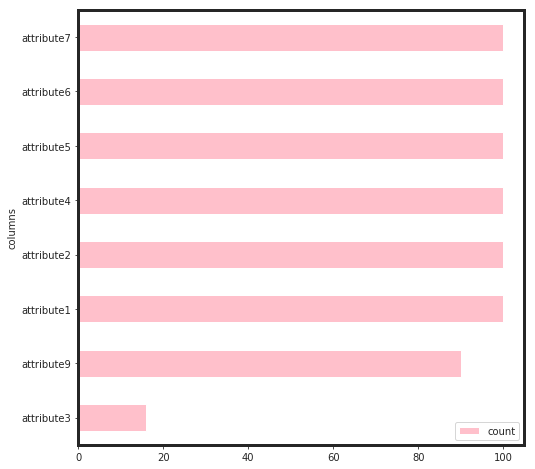

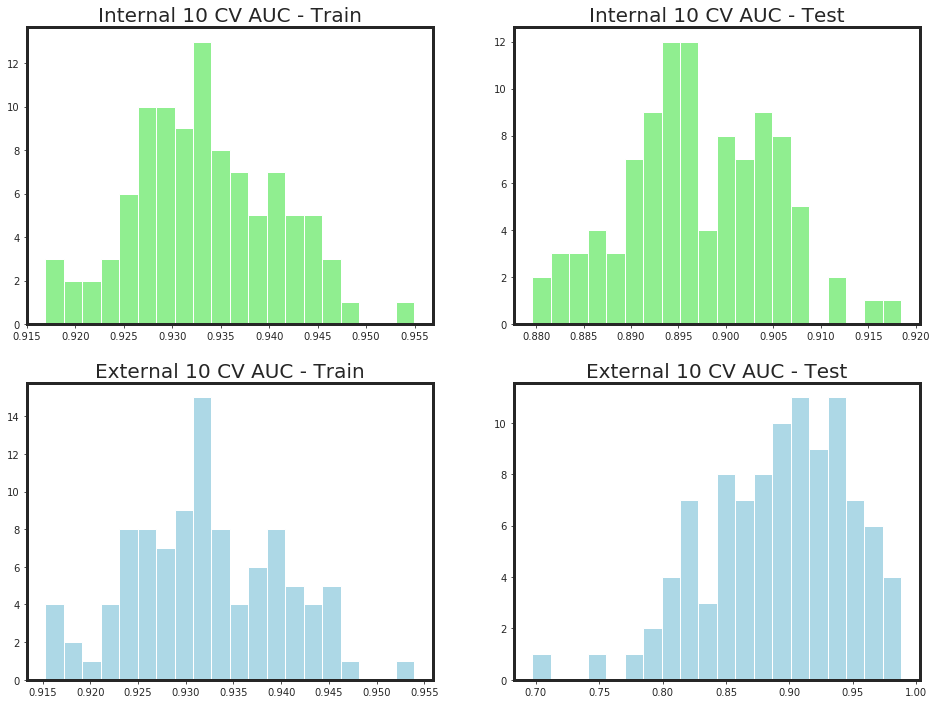

In [14]:
# choosing params to under-fit the model for feature selection + noisy features. This would help to have simpler model
params = {
          "learning_rate" : 0.05,
          "max_depth": 2,
          "min_child_weight": 5,
          "gamma" : 0.5
          
         }
o_, d_ = _my_feature_selector(df_X, Y, n_iter = 10,
                                       params = params,
                                       seed = 1367,
                                       callbacks = False)

In [35]:
params = {
          "learning_rate" : 0.05,
          "max_depth": 2,
          "min_child_weight": 5.,
          "gamma" : 0.5
         }
bst, cvr = _bst_shap(df_X, Y, params = params, callbacks = True)

-*-*-*-*-*-*-* CV Started *-*-*-*-*-*-*-
[22:09:38] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[22:09:38] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[22:09:38] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[22:09:39] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[22:09:39] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[22:09:39] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[22:09:39] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[22:09:39] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[22:09:39] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[22:09:39] Tree method is selected to be 'hist', which uses a single updater 

[171]	train-auc:0.912856	test-auc:0.890256
[172]	train-auc:0.912859	test-auc:0.890457
[173]	train-auc:0.914933	test-auc:0.885244
[174]	train-auc:0.917162	test-auc:0.888691
[175]	train-auc:0.919827	test-auc:0.893754
[176]	train-auc:0.921293	test-auc:0.898306
[177]	train-auc:0.921269	test-auc:0.898513
[178]	train-auc:0.922025	test-auc:0.900192
[179]	train-auc:0.922283	test-auc:0.898478
[180]	train-auc:0.922729	test-auc:0.896203
[181]	train-auc:0.922026	test-auc:0.89636
[182]	train-auc:0.922845	test-auc:0.89517
[183]	train-auc:0.922994	test-auc:0.89481
[184]	train-auc:0.923685	test-auc:0.893755
[185]	train-auc:0.924463	test-auc:0.89445
[186]	train-auc:0.925612	test-auc:0.895708
[187]	train-auc:0.925986	test-auc:0.896097
[188]	train-auc:0.926308	test-auc:0.898049
[189]	train-auc:0.926701	test-auc:0.89994
[190]	train-auc:0.926804	test-auc:0.900076
[191]	train-auc:0.927169	test-auc:0.899289
[192]	train-auc:0.927667	test-auc:0.898406
[193]	train-auc:0.927906	test-auc:0.898717
[194]	train-auc:

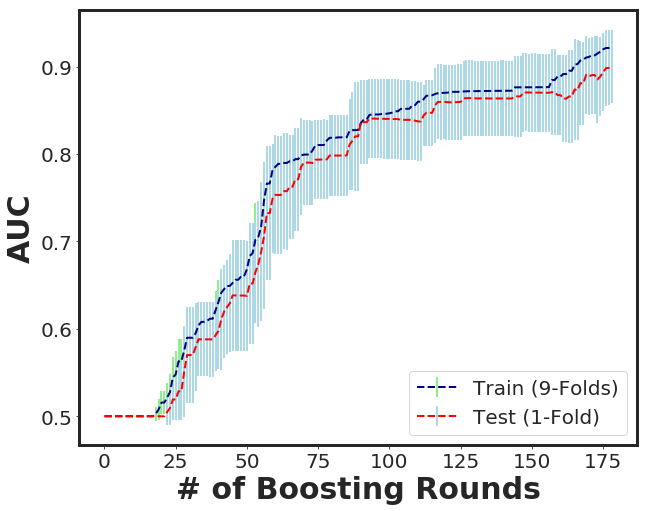

In [36]:
_plot_xgboost_cv_score(cvr)

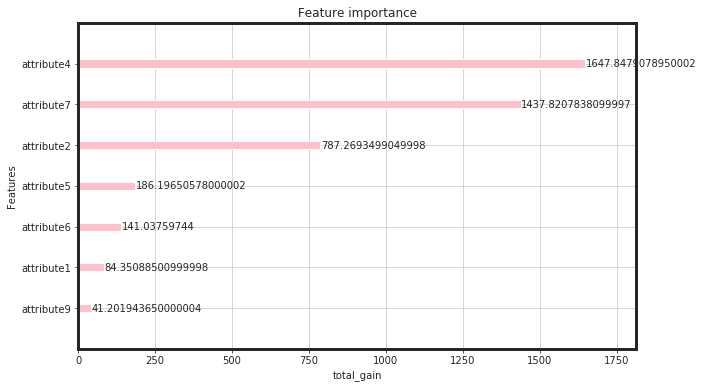

In [37]:
_plot_importance(bst, figsize=(10,6), importance_type = "total_gain")

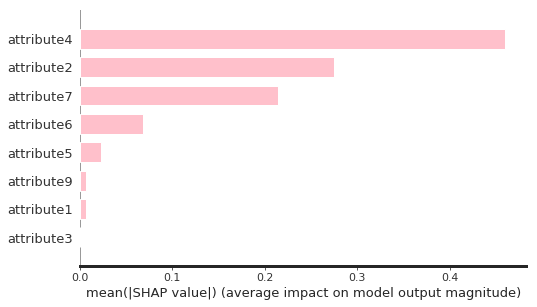

In [39]:
Tree_explainer = shap.TreeExplainer(bst)
shap_Treevalues = Tree_explainer.shap_values(df_X)
shap.summary_plot(shap_Treevalues, df_X, plot_type = "bar", color = "pink", max_display = 10)

### As seen, attribute3 has not played an important role through the feature selection process. Therefore, I dropped it and build the final model based on that.

In [40]:
df_pruned = df_X.drop(["attribute3"], axis = 1)

### As seen, the total gain for attribute4, attirbute7, and attribute 2 are higher than the rest. This would say that, for linear models such as regulirized linear models including elastic net, these features will be pruned. Now, we can see, how these features perform:

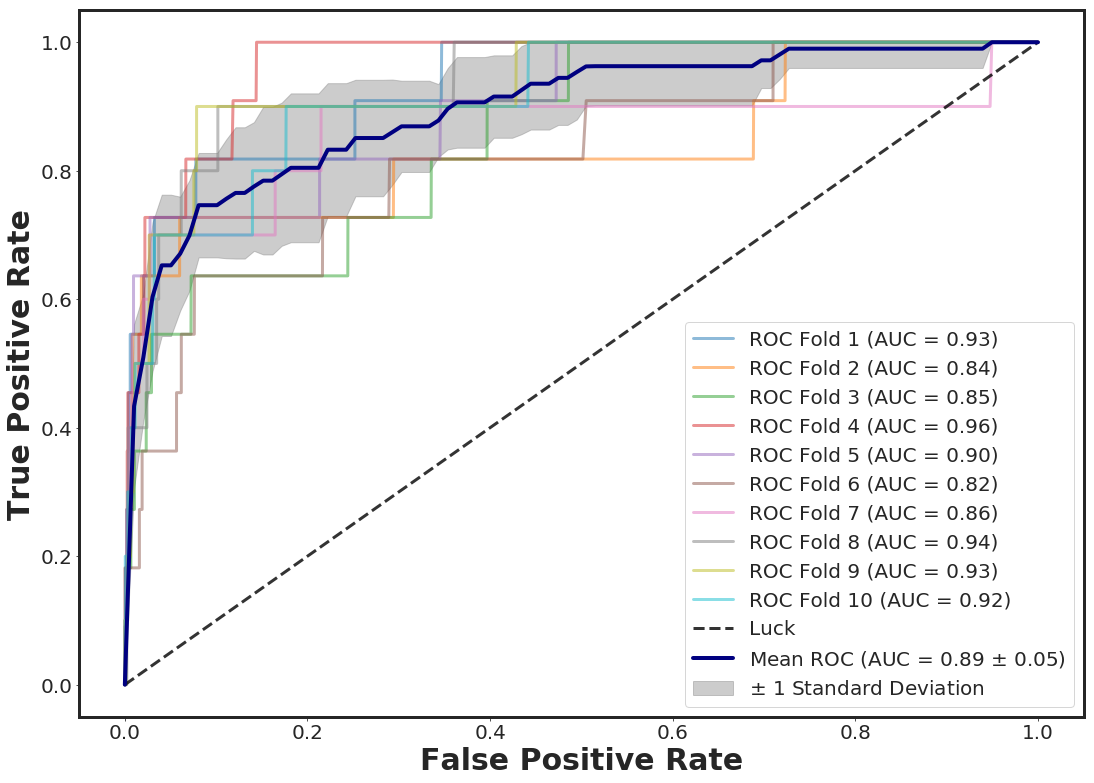

In [18]:
_plot_roc_nfolds_xgboost(df_pruned, Y)

Accuracy for test size 0.3  = 0.99914
ROC for test size 0.3 = 0.890
Mean ROC for 10 folds CV = 0.896
Confidence Interval Accuracy = [0.887 , 0.893]
Normalized confusion matrix
[[0.91 0.09]
 [0.25 0.75]]


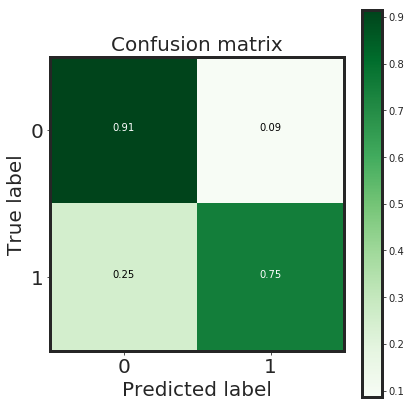

In [26]:
test_size = 0.3
n_folds = 10
accuracy_score, roc_score, cv_roc_score, y_pred_prob, X_test, y_test, optimal_threshold = _clf_xgboost(df_pruned, Y, test_size, n_folds)
CI_neg, CI_pos = _ConfidenceInterval(roc_score, X_test.shape[0])
print(F"Accuracy for test size {test_size}  = {accuracy_score:.5f}")
print(F"ROC for test size {test_size} = {roc_score:.3f}")
print(F"Mean ROC for {n_folds} folds CV = {cv_roc_score.mean():.3f}")
print(F"Confidence Interval Accuracy = [{CI_neg:.3f} , {CI_pos:.3f}]")

class_names = [0, 1]
#optimal threshold based on Youden Index
y_pred = (y_pred_prob[:,1] > optimal_threshold).astype(int)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
# Plot normalized confusion matrix
plt.figure(figsize=(6,6))
_plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = True)
plt.show()

# Discussion:
### As seen, the xgboost approach showed a good performance in terms of classification of the individuals in terms of Failure and Non-failure. The classification problem is an imbalanced problem (prevalence < 1%). Therefore, the classification accuracy by itself cannot be trusted and the other classification metrics such as area under ROC curve and Precision-Recalls or F-1 score which are robust to imbalanced classes should be used. The other challenge is the size of the dataset. In fact, we are looking for a model that can be generalized to a larger population. In this regard, it is also better to report the classification error with a confidence interval at a statistical significance level. For instance, to have 95% significance, we can calculate the classification error from the following formula using the Z-score of 1.96:

$ConfidenceInterval = Score \pm 1.96 \times \sqrt{ \frac{Score \times (1 - Score)}{N}}$

### For instance, for the approach , we have N= 37349 (30% of the data) individuals in the testing set (unseen individuals) with an AUC of 0.89 which is within the calculated 95% confidence interval. Now, we can add the prediction pribabilities for both class 0 and 1 to the test data.

In [27]:
X_test["pred_proba_class_0"] = pd.Series(y_pred_prob[:,0], index = X_test.index)
X_test["pred_proba_class_1"] = pd.Series(y_pred_prob[:,1], index = X_test.index)

In [28]:
print(F"Test Size = {X_test.shape}")
X_test.head()

Test Size = (37349, 9)


,attribute1,attribute2,attribute4,attribute5,attribute6,attribute7,attribute9,pred_proba_class_0,pred_proba_class_1
22999,0.394775,-0.073170,-0.076004,-0.202137,-0.414557,-0.039335,-0.065047,0.999829,0.000171
26237,-1.097957,0.844409,-0.076004,0.613269,-2.623549,-0.039335,-0.065047,0.997224,0.002776
123435,-1.179217,-0.073170,-0.076004,-0.515755,0.573101,-0.039335,-0.065047,0.999710,0.000290
120834,0.404221,-0.073170,-0.076004,-0.515755,1.461849,-0.039335,-0.065047,0.999801,0.000199
31117,0.243279,-0.073170,-0.076004,1.428676,0.208837,-0.039335,-0.065047,0.999160,0.000840


### Now we can repeat this process for N times (let's do 100 times) and check the histograms of auc for 95% significance level.

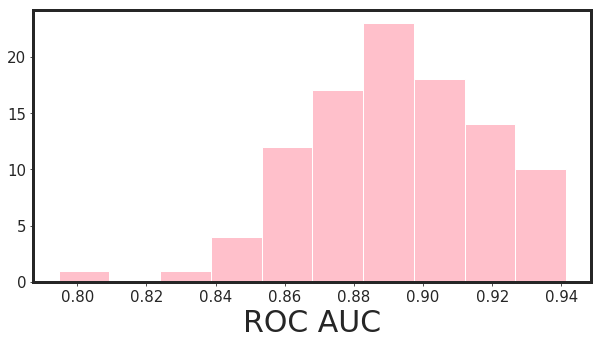

95.0% Significance Level - ROC AUC Confidence Interval= [0.849 , 0.934]


In [29]:
_xgboost_auc_hist(df_pruned, Y, n_iterations = 100, alpha = 0.95)

### Note that, in this example I have chosen the hyper-parameters based on rule of thumb and my experience. However, for finalizing the model, an exhaustive GridSearch or Bayesian Optimization is needed. I have not done it here due to my short time to finish this project. However, for all of my model that went to production so far, I do use hyper-parameter tuning.

# 2nd Approach: Regularized Linear Model

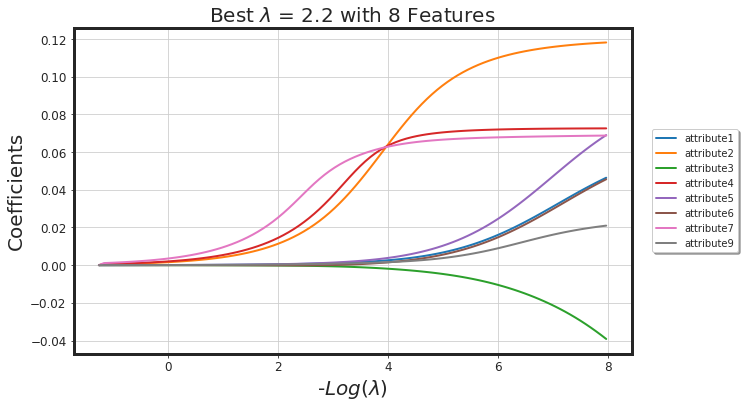

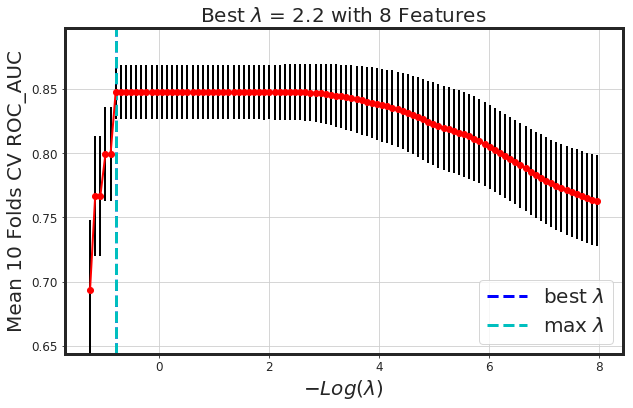

,Features,Coeffs
0,attribute7,0.001592
1,attribute4,0.000901
2,attribute2,0.000707
3,attribute5,0.000030
4,attribute1,0.000027
5,attribute9,0.000022
6,attribute6,-0.000007
7,attribute3,-0.000013


In [48]:
# Ridge
alpha = 0.0

glmnet_model = _glmnet(df_X, Y, alpha = alpha)
_plot_glmnet_coeff_path(glmnet_model, df_X)
_plot_glmnet_cv_score(glmnet_model)
_df_glmnet_coeff_path(glmnet_model, df_X)

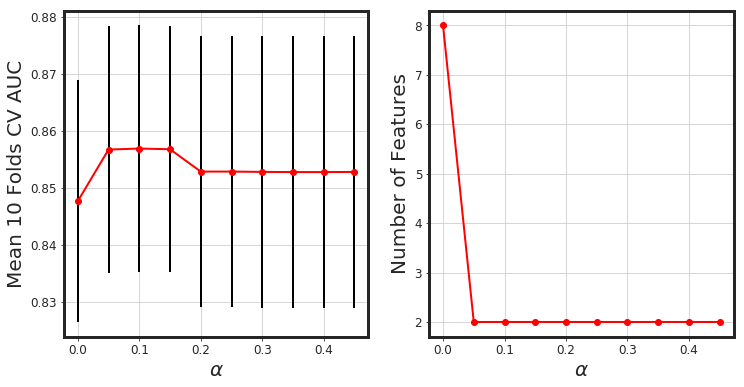

In [45]:
_glmnet_best_score_alpha(df_X, Y)

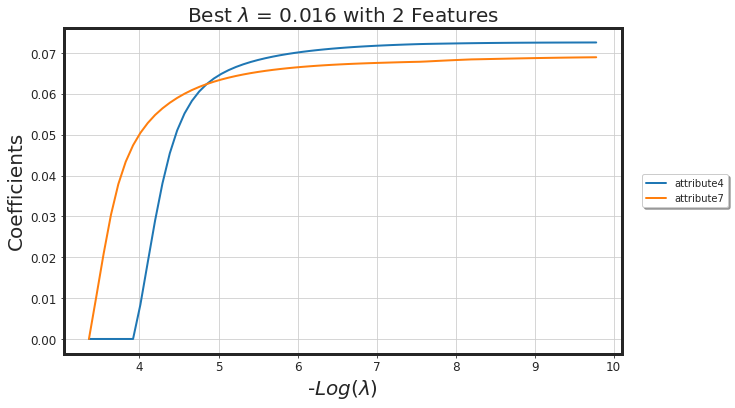

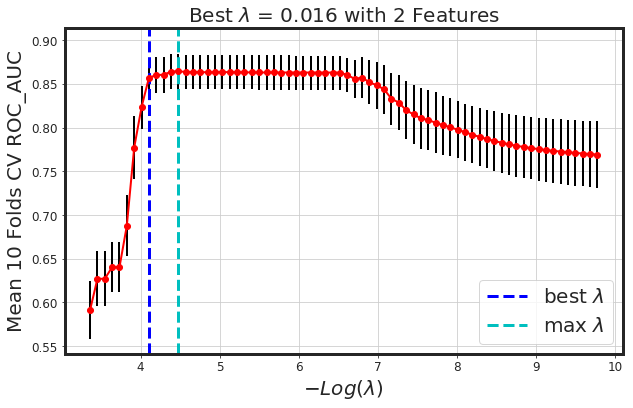

,Features,Coeffs
0,attribute7,0.052871
1,attribute4,0.018768


In [49]:
# Elastic-Net
alpha = 0.1

glmnet_model = _glmnet(df_X, Y, alpha = alpha)
_plot_glmnet_coeff_path(glmnet_model, df_X)
_plot_glmnet_cv_score(glmnet_model)
_df_glmnet_coeff_path(glmnet_model, df_X)

### As seen, glmnet has added more bias to the model (we lost around 4% AUC). However, the model is way more simpler. Generally, both methods along with each other would result in a more generalized model. 

# Notes could be considered:
### Other than, hyper parameter optimization (using grid search or bayesian optimization), I have not implemented any neural network models here that could be used as well (neural network without hyper-parameter optimizaiton is technically useless). Another thing that could be used is the time at event. For example, any useful information such as some specific day-of-the-month that failure happened can be engineered as a new feature (attribute). In addition to this, the device include 1169 unique values where failure happened for 106 of them.

In [64]:
g = df_raw.groupby("device").agg({"failure" : "mean"}).sort_values(by = ["failure"], ascending = False)
g = g.reset_index(level=["device"])
print(F"Number of groups with non-zero failure rate = {g[g['failure'] > 0].shape[0]}")
g.head(10)

Number of groups with non-zero failure rate = 106


,device,failure
0,S1F0RRB1,0.200000
1,S1F10E6M,0.142857
2,S1F11MB0,0.142857
3,S1F0CTDN,0.142857
4,Z1F1AG5N,0.111111
5,W1F0PNA5,0.111111
6,W1F13SRV,0.076923
7,W1F03DP4,0.071429
8,W1F1230J,0.071429
9,W1F0T034,0.058824


### For instance, the rows that include the device "S1F0RRB1" has 20% failure rate. In better words, these sets of devices (106) can be used as binary features. However, I was not sure that this is the goal or not. In fact, I am not sure, if would ruin the model since it brings the information from future with knowing the nature of the device. The other note would be for k-folds cross-validation. This devices can be used to group the data into stratified-group-k-folds for classificaiton. In better words, all the rows for specific groups go into the same folds.